In [2]:
from accelerate import Accelerator
import json 
import os 
from typing import Dict, Any


def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config

accelerator = Accelerator()
device = accelerator.device

config = load_config('eval_config.json')


In [3]:
from maskgen.utils.save_utils import load_pixel_heatmap_pairs
npz_path = os.path.join(config['results_path'],'pixel_heatmap_pairs.npz')
dataloader = load_pixel_heatmap_pairs(npz_path, batch_size=1, shuffle=False)

In [8]:
from maskgen.evaluation import EvalGame
from maskgen.utils.model_utils import get_pred_model
import numpy as np

processor, pred_model = get_pred_model(config['pretrained_name'], device)
pred_model.eval() 
target_model = lambda x: pred_model(x).logits

eval_game = EvalGame(target_model)


del_score_list = []
ins_score_list = []
cum_del_score = 0
cum_ins_score = 0
for idx, batch in enumerate(dataloader):
    pixel_values = batch['pixel_values'].to(device)
    heatmaps = batch['heatmap'].to(device)
    del_score = eval_game.get_deletion_score(pixel_values, heatmaps)
    ins_score = eval_game.get_insertion_score(pixel_values, heatmaps)
    del_score_list.append(del_score)
    ins_score_list.append(ins_score)
    cum_del_score += del_score.item()
    cum_ins_score += ins_score.item()
    print(f'Batch {idx} - Del AUC: {del_score:.4f}, Ins AUC: {ins_score:.4f}')
    print(f'Current Del AUC: {cum_del_score / len(del_score_list):.4f}, Current Ins AUC: {cum_ins_score / len(ins_score_list):.4f}')


Batch 0 - Del AUC: 2.7599, Ins AUC: 92.2908
Current Del AUC: 2.7599, Current Ins AUC: 92.2908
Batch 1 - Del AUC: 67.9742, Ins AUC: 90.3706
Current Del AUC: 35.3670, Current Ins AUC: 91.3307
Batch 2 - Del AUC: 8.2125, Ins AUC: 8.1875
Current Del AUC: 26.3155, Current Ins AUC: 63.6163
Batch 3 - Del AUC: 0.6949, Ins AUC: 5.6593
Current Del AUC: 19.9103, Current Ins AUC: 49.1270
Batch 4 - Del AUC: 41.7716, Ins AUC: 85.2600
Current Del AUC: 24.2826, Current Ins AUC: 56.3536
Batch 5 - Del AUC: 43.9276, Ins AUC: 75.1127
Current Del AUC: 27.5568, Current Ins AUC: 59.4801
Batch 6 - Del AUC: 42.3872, Ins AUC: 93.9324
Current Del AUC: 29.6754, Current Ins AUC: 64.4019
Batch 7 - Del AUC: 17.0646, Ins AUC: 78.2022
Current Del AUC: 28.0990, Current Ins AUC: 66.1269
Batch 8 - Del AUC: 3.2966, Ins AUC: 34.3974
Current Del AUC: 25.3432, Current Ins AUC: 62.6014
Batch 9 - Del AUC: 9.9704, Ins AUC: 32.3463
Current Del AUC: 23.8059, Current Ins AUC: 59.5759
Batch 10 - Del AUC: 2.5713, Ins AUC: 0.6584
Curr

In [10]:
import pandas as pd

result_dict = {'idx': range(len(del_score_list)), 
               'del_score': [x.item() for x in del_score_list], 
               'ins_score': [x.item() for x in ins_score_list]}

# Save results dict to pandas dataframe and save to csv
result_df = pd.DataFrame(result_dict)
result_df.to_csv(os.path.join(config['results_path'], 'eval_results.csv'), index=False)

# Hard cases

In [11]:
from maskgen.utils.save_utils import PixelHeatmapDataset

dataset = PixelHeatmapDataset(npz_path)


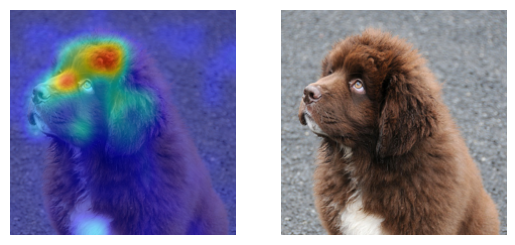

In [24]:
from maskgen.utils.img_utils import plot_overlap_np
hard_sample = dataset[796]
image = hard_sample['pixel_values']
heatmap = hard_sample['heatmap']

image = image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
heatmap = heatmap.squeeze(0).detach().cpu().numpy()

_, _ = plot_overlap_np(image, heatmap, processor.image_mean, processor.image_std)
